# Problem description / Outline

I want to work on a local dataset and since I am from Germany, I will do the following:

Berlin is famous for the distributed nature - and I want to know in which neighbourhood the most action is going on as measured by foursquare data and if that is in any way correlated to the price of living there (as measured by rent).

I will pick two "KPIs" from Foursquare to measure this, and one KPI as rent:

1. Number of Italian Restaurants
2. Number of Bars and Nightclubs
3. Rent, https://mietpreisspiegel.de/miete-in-berlin/

To collect the data, I will start with the following Wikipedia page https://en.wikipedia.org/wiki/Boroughs_and_neighborhoods_of_Berlin; this referes to each borough and neighbourhood (on separate pages), where the GPS locations are given.

Since I did not find an exact shape description of Berlin, I will use the GPS coordinate from above and define a circle around that to measure the number of KPIs, as mentioned.

I will visualize this on a map and show correlations.

# Data Collection

First, I will collect the rent prices and store them in a DataFrame. This is the simple task.

In [1]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import requests

In [2]:
url='https://mietpreisspiegel.de/miete-in-berlin/'
source = requests.get(url).content
content = BeautifulSoup(requests.get(url).content, 'html')

In [3]:
# Find and parse the table
table = content.find('table')
td = table.find_all('td')
neighbourhood = []
price = []
for i in range(0, len(td), 2):
    neighbourhood.append(td[i].text.strip())
    price.append(td[i+1].text.strip())

In [4]:
# Convert German style number (with comma instead of dot) to English style and remove the 
#  Price Unit (Euro)
price = [float(p.replace(' Euro', '').replace(',','.')) for p in price]

In [5]:
rentprices = pd.DataFrame({'Neighbourhood' : neighbourhood, 'Rent' : price})

rentprices.head()

,Neighbourhood,Rent
0,Adlershof,7.40
1,Alt-Hohenschönhausen,7.29
2,Alt-Treptow,7.04
3,Altglienicke,7.27
4,Baumschulenweg,7.07


Okay, next up: the GPS coordinates of the different neighbourhoods of Berlin!

In [6]:
url='https://en.wikipedia.org/wiki/Boroughs_and_neighborhoods_of_Berlin'
source = requests.get(url).content
content = BeautifulSoup(requests.get(url).content, 'html')

In [7]:
table_list=content.find_all('table')

neighbourhood_raw = []

neighbourhood = []
size = []
population = []
density = []

for i in range(2, 14): # These magic numbers are created by inspecting the HTML-page ...
    trs = table_list[i].find_all('tr')

    for tr in trs:
        tds = tr.find_all('td')
    
        if len(tds)>=4:
            # First line always seems to come with 5 entries, I don't know why ...
            neighbourhood_raw.append(tds[0])
            neighbourhood.append(tds[0].text.strip())
            size.append(tds[1].text.strip())
            population.append(tds[2].text.strip())
            density.append(tds[3].text.strip())

Now, I have to do some text replacement (again, converting numbers) and removing the area code e.g. (0402)

Ultimately, I want to have a data frame with this info in there.

In [8]:
# But first, a quick comparison, do I have a rent price for each Neighbourhood?

rentprices.shape, len(neighbourhood)

((96, 2), 96)

In [9]:
# Now, get the latitudinal and longitudinal info from the sub-pages:

base_url = 'https://en.wikipedia.org'

latitude = []
longitude = []

for nr in neighbourhood_raw:
    add_url = nr.find_all('a', href=True)[1]['href']

    source = requests.get(base_url + add_url).content
    content = BeautifulSoup(requests.get(base_url + add_url).content, 'html')

    spans = content.find('span', { 'class' : 'latitude' })
    latitude.append(spans.text)

    spans = content.find('span', { 'class' : 'longitude' })
    longitude.append(spans.text)

In [10]:
# Now, correct the format:

for i in range(len(neighbourhood)):
    neighbourhood[i] = ' '.join(neighbourhood[i].split()[1:]) # Throw Away the Code
    
    size[i] = float(size[i])
    population[i] = float(population[i].replace(',', ''))
    density[i] = float(density[i].replace(',', ''))
    
    # Now, I have to convert the 
    lats = latitude[i].replace('°', ' ').replace('′', ' ').replace('″', '').replace('N', '').split()
    
    minutes = lats[1]
    seconds = (0 if len(lats)==2 else lats[2])
    
    latitude[i] =  float(lats[0]) + float(minutes)/60 + float(seconds)/3600
    
    long = longitude[i].replace('°', ' ').replace('′', ' ').replace('″', '').replace('E', '').split()
    
    minutes = long[1]
    seconds = (0 if len(long)==2 else long[2])
    
    longitude[i] = float(long[0]) + float(minutes)/60 + float(seconds)/3600

In [11]:
neighbourhoods = pd.DataFrame({'Neighbourhood' : neighbourhood, 'Size' : size, 'Population' : population,
                              'Density' : density, 'Latitude' : latitude, 'Longitude' : longitude})

Now, merge the two DataFrames, the one for rent and the one for the neighbourhoods

In [12]:
neighbourhoods=pd.merge(neighbourhoods, rentprices, how='left',
                        left_on='Neighbourhood', right_on='Neighbourhood',
                        suffixes=["_x", None])

Next step: for each neighbourhood, find Italian Restaurants and Bars&Clubs via FourSquare.

For that, we define the get_venues function from last time:

In [13]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = 'USE_YOUR_OWN' 
    CLIENT_SECRET = 'USW_YOUR_OWN' 
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)

    return df

In [14]:
n,_ = neighbourhoods.shape

neighbourhoods['Italian Restaurants'] = [np.nan] * n
neighbourhoods['Bars+Clubs'] = [np.nan] * n

for i in neighbourhoods.index:
    venues = get_venues(neighbourhoods['Latitude'].loc[i], neighbourhoods['Longitude'].loc[i])
    
    italian_restaurants=venues[venues['Category']=='Italian Restaurant']
    bars = venues[venues['Category']=='Bar']
    clubs = venues[venues['Category']=='Nightclub']
    
    neighbourhoods['Italian Restaurants'].loc[i] = len(italian_restaurants)
    neighbourhoods['Bars+Clubs'].loc[i] = len(bars) + len(clubs)


/home/ed/.local/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [15]:
neighbourhoods.head()

,Neighbourhood,Size,Population,Density,Latitude,Longitude,Rent,Italian Restaurants,Bars+Clubs
0,Mitte,10.70,79582.0,7445.0,52.519444,13.406667,9.62,0.0,0.0
1,Moabit,7.72,69425.0,8993.0,52.533333,13.333333,7.03,3.0,4.0
2,Hansaviertel,0.53,5889.0,11111.0,52.516667,13.338889,8.63,3.0,0.0
3,Tiergarten,5.17,12486.0,2415.0,52.516667,13.366667,8.03,3.0,1.0
4,Wedding,9.23,76363.0,8273.0,52.550000,13.366667,6.75,1.0,12.0


Now, the data is collected!

# Exploratory Data Analysis and Methodology

First, let's do a simple correlation analysis - but before we do this, what do we expect? Latitude and Longitude will probably not contribute much, we should throw them out.

Density will probably be correlated with Rent prices, and Nightlife might be negatively correlated.

Please note that density = population/size, so there is a dependacy there

In [16]:
neighbourhoods.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96 entries, 0 to 95
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Neighbourhood        96 non-null     object 
 1   Size                 96 non-null     float64
 2   Population           96 non-null     float64
 3   Density              96 non-null     float64
 4   Latitude             96 non-null     float64
 5   Longitude            96 non-null     float64
 6   Rent                 96 non-null     float64
 7   Italian Restaurants  96 non-null     float64
 8   Bars+Clubs           96 non-null     float64
dtypes: float64(8), object(1)
memory usage: 10.0+ KB


Okay, looks like I did a good job, data seems complete.

In [17]:
neighbourhoods.describe()

,Size,Population,Density,Latitude,Longitude,Rent,Italian Restaurants,Bars+Clubs
count,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000
mean,9.257604,35033.656250,4697.302083,52.513177,13.399844,7.481354,1.375000,0.833333
std,6.434435,34338.111481,4120.801471,0.066580,0.126404,0.826537,1.718322,2.606335
min,0.530000,450.000000,144.000000,52.366667,13.141389,5.740000,0.000000,0.000000
25%,5.455000,10717.750000,1687.750000,52.457569,13.316667,7.030000,0.000000,0.000000
50%,7.760000,22012.500000,3301.500000,52.516667,13.390139,7.350000,1.000000,0.000000
75%,11.175000,46334.250000,5830.250000,52.567500,13.494167,7.855000,2.000000,0.000000
max,34.900000,154127.000000,16204.000000,52.633611,13.700000,10.150000,10.000000,15.000000


In [18]:
!pip3 install seaborn

In [19]:
import seaborn as sns

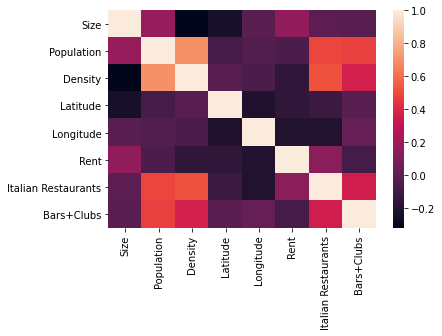

In [20]:
sns.heatmap(neighbourhoods.corr())

Wow, not much going on there. Density is correlated to Restaurants and Bars&Clubs, but population is also correlated there.

Rent correlates mildly with size and Italian Restaurants - maybe.

But I might have picked a hard exercise here :-)

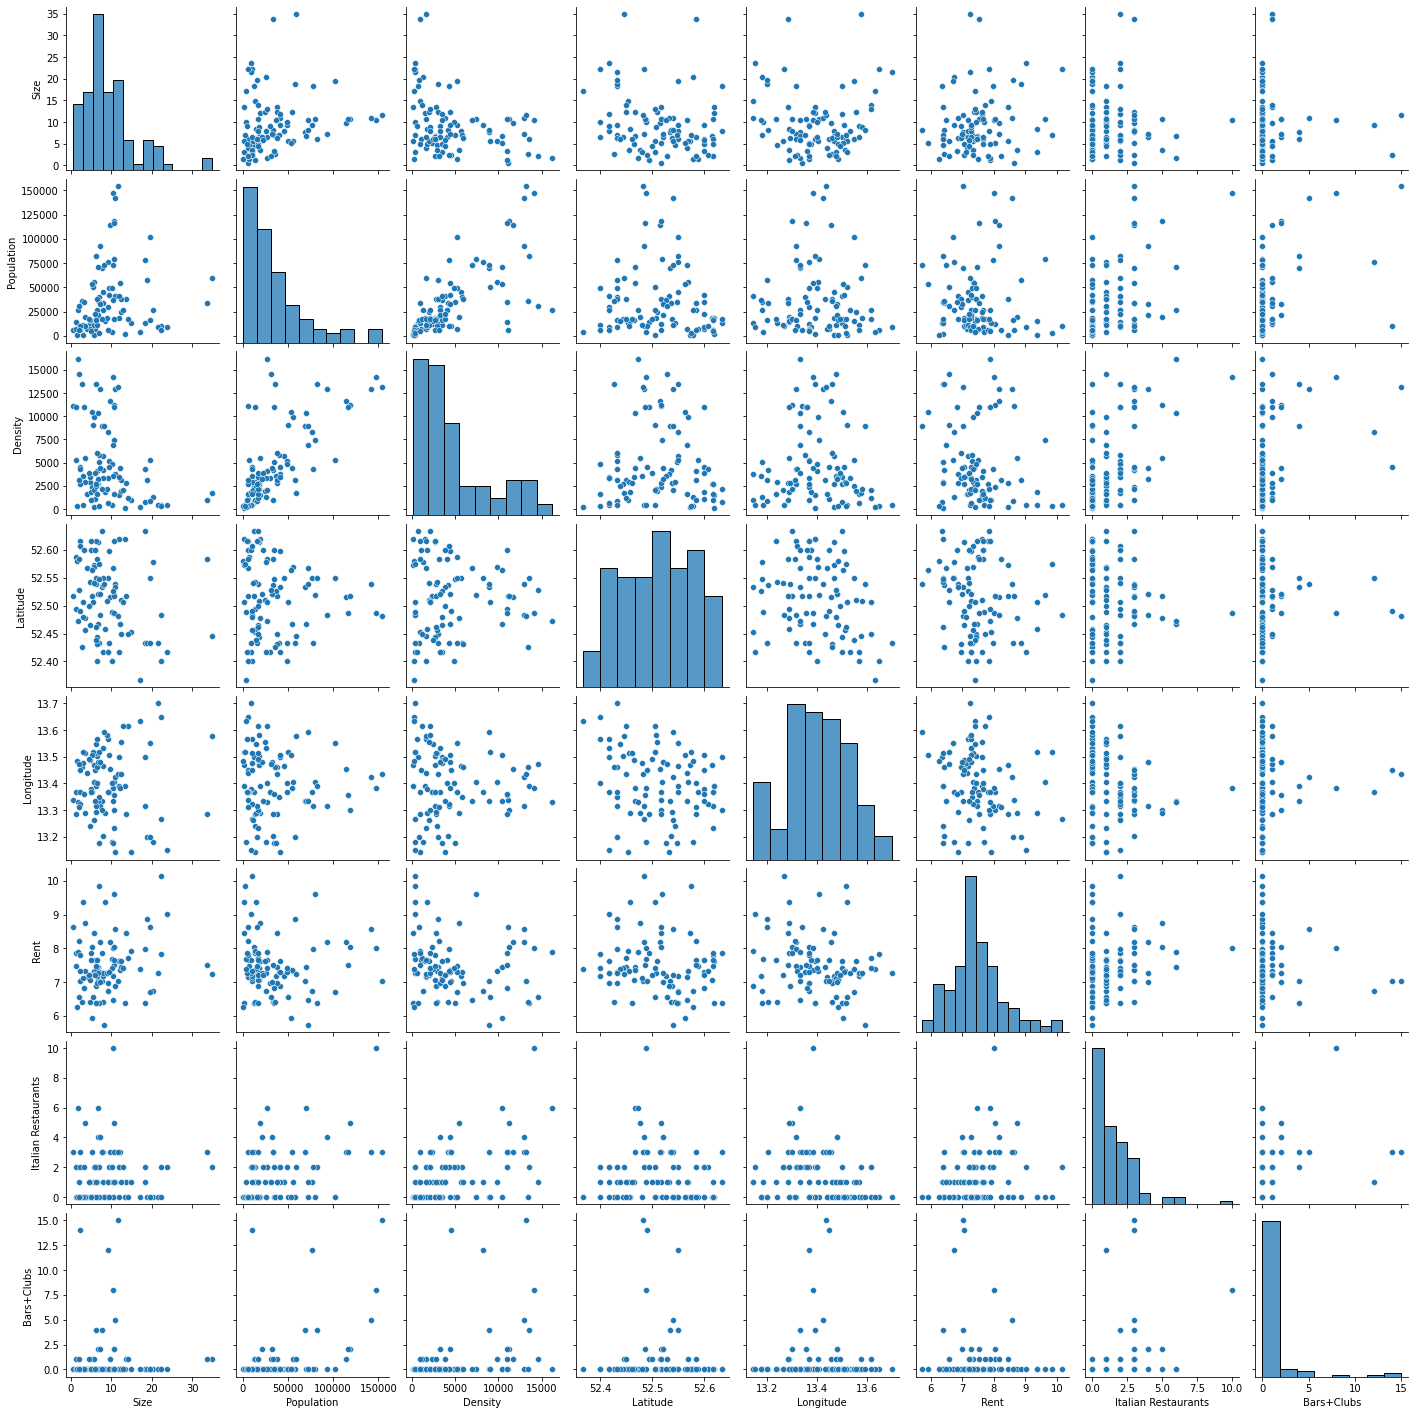

In [21]:
sns.pairplot(neighbourhoods)

The pairplot confirms our initial idea - there is not much correlation there.

Also note that almost no variable here follows a normal distribution (except maybe rent).

Especially bars+clubs and Restaurants look like power laws at first glance.

Okay - let's try some prediction of the rent anyways and compare some models.

In [22]:
y = neighbourhoods['Rent']

neighbourhoods_red = neighbourhoods.drop(['Latitude', 'Longitude', 'Rent'], axis=1)

neighbourhoods_red.set_index('Neighbourhood', inplace=True)

neighbourhoods_red.head()

,Size,Population,Density,Italian Restaurants,Bars+Clubs
Neighbourhood,,,,,
Mitte,10.70,79582.0,7445.0,0.0,0.0
Moabit,7.72,69425.0,8993.0,3.0,4.0
Hansaviertel,0.53,5889.0,11111.0,3.0,0.0
Tiergarten,5.17,12486.0,2415.0,3.0,1.0
Wedding,9.23,76363.0,8273.0,1.0,12.0


In [23]:
from sklearn.model_selection import train_test_split

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    neighbourhoods_red, y, test_size=0.3, random_state=42)

First, try a regression model

The mean squared error for the preidiction is:  0.8025794109438622
The mean squared error if I always predict the average is:  0.7130286270653933


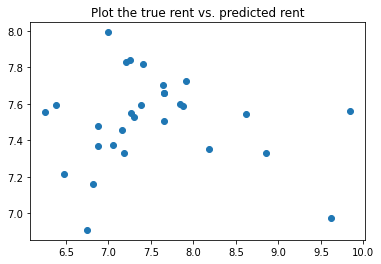

In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

lm = LinearRegression()
lm.fit(X_train, y_train)

y_hat = lm.predict(X_test)

print('The mean squared error for the preidiction is: ', mean_squared_error(y_test, y_hat))
print('The mean squared error if I always predict the average is: ', mean_squared_error(y_test, [y_train.mean()]*len(y_test)))
plt.scatter(y_test, y_hat)
plt.title('Plot the true rent vs. predicted rent')
plt.show()

This model is an utter failure. It performes worse than a simple prediction of the average rent of my train set.

Let's look if it gets better if I scale the data

In [26]:
from sklearn.preprocessing import StandardScaler

The mean squared error for the preidiction is:  0.8025794109438623
The mean squared error if I always predict the average is:  0.7130286270653933


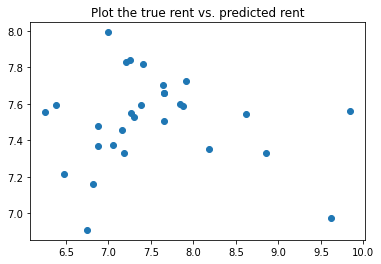

In [27]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

lm = LinearRegression()
lm.fit(X_train_scaled, y_train)

y_hat = lm.predict(X_test_scaled)

print('The mean squared error for the preidiction is: ', mean_squared_error(y_test, y_hat))
print('The mean squared error if I always predict the average is: ', mean_squared_error(y_test, [y_train.mean()]*len(y_test)))
plt.scatter(y_test, y_hat)
plt.title('Plot the true rent vs. predicted rent')
plt.show()

Not much improvement here. I could now try to create more features (interaction features), but I will not do that for now.

I will move on to a different tool ... random forrest is popular, why not try.

In [28]:
from sklearn.ensemble import RandomForestRegressor

The mean squared error for the preidiction is:  1.089568634827588
The mean squared error if I always predict the average is:  0.7130286270653933


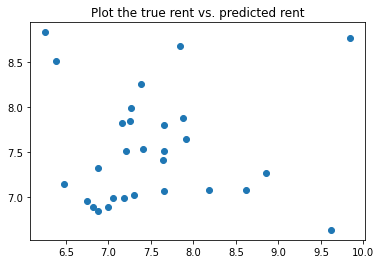

In [29]:
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

y_hat = rf.predict(X_test)

print('The mean squared error for the preidiction is: ', mean_squared_error(y_test, y_hat))
print('The mean squared error if I always predict the average is: ', mean_squared_error(y_test, [y_train.mean()]*len(y_test)))
plt.scatter(y_test, y_hat)
plt.title('Plot the true rent vs. predicted rent')
plt.show()

Ouch. Even worse. Use scaled data as well next time:

The mean squared error for the preidiction is:  1.0903476213793122
The mean squared error if I always predict the average is:  0.7130286270653933


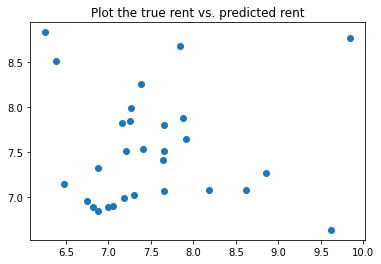

In [30]:
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train_scaled, y_train)

y_hat = rf.predict(X_test_scaled)

print('The mean squared error for the preidiction is: ', mean_squared_error(y_test, y_hat))
print('The mean squared error if I always predict the average is: ', mean_squared_error(y_test, [y_train.mean()]*len(y_test)))
plt.scatter(y_test, y_hat)
plt.title('Plot the true rent vs. predicted rent')
plt.show()

Hmm, not much luck here as well in beating a stupidly simple baseline.

Maybe I have to do some feature engineering here ... insert an inverse feature:

In [31]:
neighbourhoods_red['Inverse Restaurants'] = 20-neighbourhoods_red['Italian Restaurants']

In [32]:
X_train, X_test, y_train, y_test = train_test_split(
    neighbourhoods_red, y, test_size=0.3, random_state=42)

The mean squared error for the preidiction is:  0.8025794109438621
The mean squared error if I always predict the average is:  0.7130286270653933


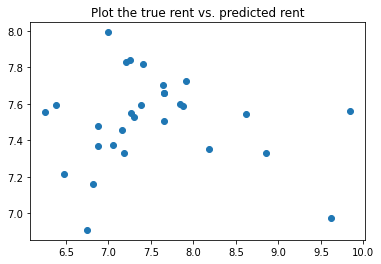

In [33]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

lm = LinearRegression()
lm.fit(X_train_scaled, y_train)

y_hat = lm.predict(X_test_scaled)

print('The mean squared error for the preidiction is: ', mean_squared_error(y_test, y_hat))
print('The mean squared error if I always predict the average is: ', mean_squared_error(y_test, [y_train.mean()]*len(y_test)))
plt.scatter(y_test, y_hat)
plt.title('Plot the true rent vs. predicted rent')
plt.show()

Okay, does not work well either. I will try a KNN approach and a NN approach going forward to see, if this improves.

Otherwise, I will rest my case.

k_min:  14
The mean squared error for the preidiction is:  0.8110717098678047
The mean squared error if I always predict the average is:  0.7130286270653933


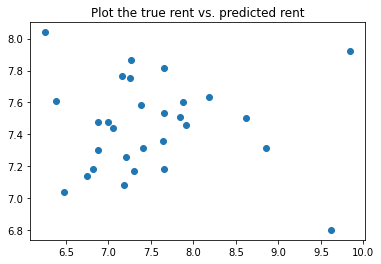

In [34]:
from sklearn.neighbors import KNeighborsRegressor

min_k = 1
min_err=1000000
for k in range(1,15):
    knn = KNeighborsRegressor(k, weights='distance')
    knn.fit(X_train_scaled, y_train)

    y_hat = knn.predict(X_test_scaled)
    
    err = mean_squared_error(y_test, y_hat)
    
    if err < min_err:
        min_err = err
        min_k = k

knn = KNeighborsRegressor(min_k, weights='distance')
knn.fit(X_train_scaled, y_train)

y_hat = knn.predict(X_test_scaled)
    
print("k_min: ", min_k)
print('The mean squared error for the preidiction is: ', mean_squared_error(y_test, y_hat))
print('The mean squared error if I always predict the average is: ', mean_squared_error(y_test, [y_train.mean()]*len(y_test)))
plt.scatter(y_test, y_hat)
plt.title('Plot the true rent vs. predicted rent')
plt.show()

That did not work particularly well, either ... So, for the big guns, NN.

The mean squared error for the preidiction is:  1.3881293321092847
The mean squared error if I always predict the average is:  0.7130286270653933


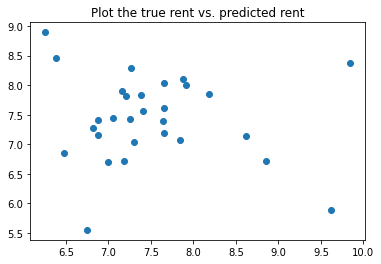

In [35]:
from sklearn.neural_network import MLPRegressor

regr = MLPRegressor(random_state=1, max_iter=500000).fit(X_train_scaled, y_train)

y_hat = regr.predict(X_test_scaled)

print('The mean squared error for the preidiction is: ', mean_squared_error(y_test, y_hat))
print('The mean squared error if I always predict the average is: ', mean_squared_error(y_test, [y_train.mean()]*len(y_test)))
plt.scatter(y_test, y_hat)
plt.title('Plot the true rent vs. predicted rent')
plt.show()

Hmm. My project failed. I will do some final geospacial plots to see more of what is going on.

In [36]:
import folium

tmap = folium.Map(location=[neighbourhoods['Latitude'].mean(), neighbourhoods['Longitude'].mean()], zoom_start=12)

locations = folium.map.FeatureGroup()
prices = folium.map.FeatureGroup()

for i in neighbourhoods.index:
    lat = neighbourhoods.loc[i]['Latitude']
    lng = neighbourhoods.loc[i]['Longitude']
    
    num_locations = neighbourhoods.loc[i]['Italian Restaurants'] + neighbourhoods.loc[i]['Bars+Clubs']
    
    rent = neighbourhoods.loc[i]['Rent']
        
    locations.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=10 + num_locations,
            color='blue',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6))
    
    
    prices.add_child(
        folium.features.CircleMarker(
            [lat+0.001, lng+0.001],
            radius=10 + rent,
            color='red',
            fill=True,
            fill_color='red',
            fill_opacity=0.6))

tmap.add_child(locations)
tmap.add_child(prices)

tmap

Even this picture shows it: the red circles (scaled by size for rent) are fairly evenly distributed, the blue vary much more in size.

# Results

A prediction of the rent price based on Population Density, Restaurants and Bars and Clubs did not work out.

Most likely, a factor like "quality of restaurant", "average price per meal" or "income" is seriously lacking. 

# Discussion / Conculsion

Data Science is hard.

My project was not a big success. I learned some stuff, but mostly, I failed, because, I think, my data set was not mighty enough to solve the problem I posed.

Some general remarks:

I put data from different sources together pretty carelessly and I also did not check how complete and trustworthy they really are. However, the results "pass the smell test", but I would not make any strong claims here.